In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.express as px

In [2]:
# read in the bootstrapped data
bootstrap_data = pd.read_csv('E31_targetmol_with_bootstrap.csv')
# read in the compound names to go with this dataset
compound_data = pd.read_csv('compounds.csv')

# rename coluns and drop concentration well
compound_data = compound_data.rename(columns={'well':'Metadata_well', 'compound ':'compound'})
compound_data = compound_data.drop_duplicates(subset=['Metadata_well'])

In [3]:
compound_data = compound_data.drop("concentration", axis = 1)

In [4]:
bootstrap_data = bootstrap_data.rename(columns={'conc':'concentration'})

Data= pd.merge(compound_data, bootstrap_data, how='left', on='Metadata_well')

## senescence score

In [5]:
#group data by plate name 
#calculate 4std above mean DMSO controls per plate 

grouped = Data.groupby(['Metadata_platename'], as_index=False)
tot = []

for name, plate in grouped:
    #print(name)
    #print(plate)
    new_dat = (np.mean(plate.loc[plate['compound']== 'Targetmol_DMSO']['sen_score'])) + plate['boostrapped_senscore_mean_std']*4
    tot.append(new_dat)

col_new = pd.concat(tot)
Data["DMSOsen_score+bootstrap_std4"] = col_new
        
#creating a dataframe of compounds higher than 4 stds from the DMSO mean sen_score and with more than 200 cells 
interesting_cell_number = 200

higher = Data.loc[(Data['sen_score']>Data['DMSOsen_score+bootstrap_std4'])]

higher_200 = higher.loc[(higher['cell_no']>interesting_cell_number)]

#creating a compound list

higher_list = higher_200.compound.tolist()

#creating a dataframe of all compounds appearing in the list 

Allhigherdata = pd.DataFrame(Data[Data['compound'].isin(higher_list)])

#column 'higher' indicates which concentrations of the interesting compounds are significant

Allhigherdata['higher'] = np.where((Allhigherdata['sen_score'] > Allhigherdata['DMSOsen_score+bootstrap_std4']) & (Allhigherdata['cell_no'] > interesting_cell_number), True, False)

Allhigherdata = pd.DataFrame(Allhigherdata.sort_values('concentration'))

In [6]:
#exporting

file_name = 'E31_bootstrap_higher_compounds.csv'

Allhigherdata.to_csv(file_name)

## fraction senescent

In [7]:
#calculate number senescent and create column

Data['number_sen'] = Data['fraction_sen']*Data['cell_no']

#group data by plate name 
#calculate 4std above mean DMSO controls per plate 

tot_fraction = []

for name, plate in grouped:
    #print(plate.loc[plate['compound']=='DMSO']['fraction_sen'])
    #print(name, plate)
    new_data = (np.mean(plate.loc[plate['compound']=='Targetmol_DMSO']['fraction_sen']))*plate['cell_no'] + ((plate['boostrapped_numcells_mean_std'])*4)
    tot_fraction.append(new_data)
    
column_new = pd.concat(tot_fraction)
Data["DMSOnumber_sen+bootstrap_std4"] = column_new
        
#creating a dataframe of compounds higher than two stds from the DMSO mean senescent number and with more than 200 cells 

higher_number_sen = Data.loc[(Data['number_sen']>Data['DMSOnumber_sen+bootstrap_std4'])]

higher_200_number_sen = higher_number_sen.loc[(higher_number_sen['cell_no']>interesting_cell_number)]

#list of interesting compounds

higher_list_number_sen = higher_200_number_sen.compound.tolist()

#dataframe of interesting compounds at all concentrations 

FractionAllhigherdata = pd.DataFrame(Data[Data['compound'].isin(higher_list_number_sen)])

#column 'higher' indicating which concentrations of the interesting compounds are significant

FractionAllhigherdata['higher'] = np.where((FractionAllhigherdata['number_sen'] > FractionAllhigherdata['DMSOnumber_sen+bootstrap_std4']) & (FractionAllhigherdata['cell_no'] > interesting_cell_number), True, False)

FractionAllhigherdata = pd.DataFrame(FractionAllhigherdata.sort_values('concentration'))


In [8]:
#exporting

file_name = 'E31_bootstrap_higher_compounds_fraction.csv'

FractionAllhigherdata.to_csv(file_name)

## data visualisation

Text(0.5, 1.0, 'E31')

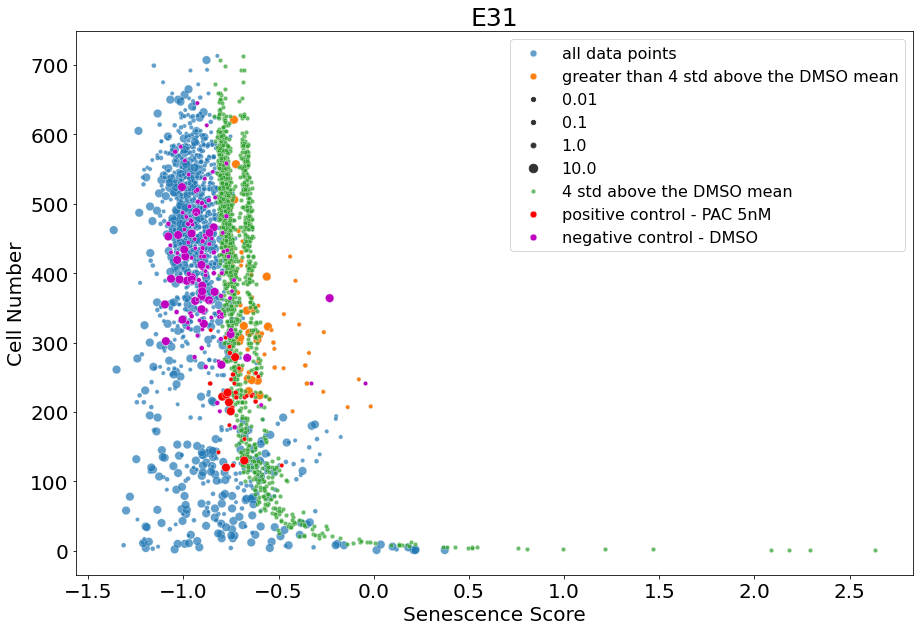

In [9]:
negative_control = (Data.set_index(['compound'])).loc[['Targetmol_DMSO']]

positive_control = (Data.set_index(['compound'])).loc[['Targetmol_PAC-5nM']]


fig, axes = plt.subplots(1, figsize=(15,10))


sb.scatterplot(data=Data, y='cell_no', x='sen_score', s=20, label='all data points', legend=False, alpha=0.7, size='concentration')
sb.scatterplot(data=higher_200, y='cell_no', x='sen_score', label='greater than 4 std above the DMSO mean', s=20, size='concentration')
sb.scatterplot(data=Data, y='cell_no', x='DMSOsen_score+bootstrap_std4', s=20, alpha=0.7, label= '4 std above the DMSO mean')
sb.scatterplot(data=positive_control, y='cell_no', x='sen_score', label='positive control - PAC 5nM', color='r', size='concentration', legend=False)
sb.scatterplot(data=negative_control, y='cell_no', x='sen_score', label='negative control - DMSO', color='m', size='concentration', legend=False)

plt.legend(fontsize=16)
plt.xlabel('Senescence Score', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Cell Number', fontsize=20)
plt.title('E31', fontsize=25)


Text(0, 0.5, 'Cell Number')

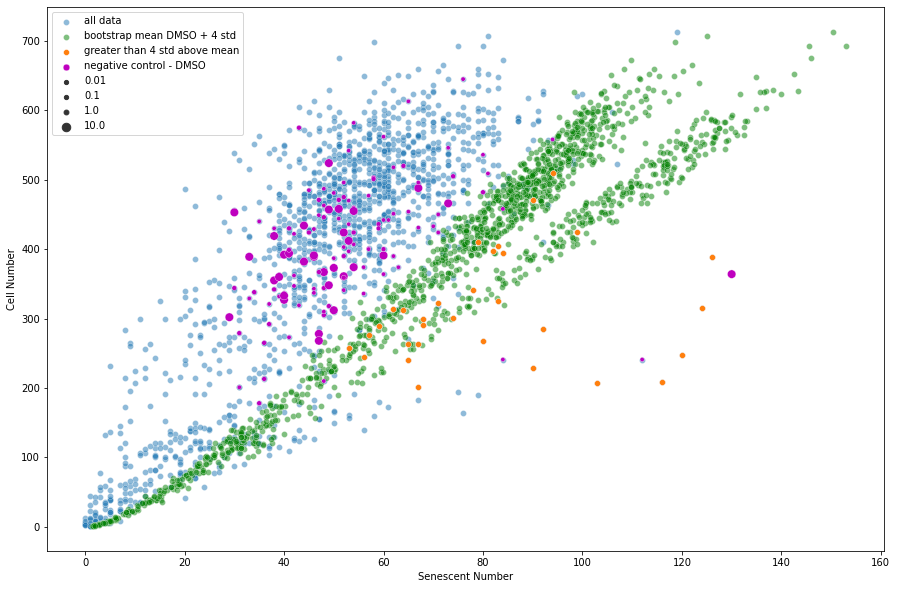

In [10]:
fig, axes = plt.subplots(1, figsize=(15,10))


sb.scatterplot(data=Data, y='cell_no', x='number_sen', alpha=0.5, label='all data')
sb.scatterplot(data=Data, y='cell_no', x='DMSOnumber_sen+bootstrap_std4', alpha=0.5, color='g', label='bootstrap mean DMSO + 4 std')
sb.scatterplot(data=higher_200_number_sen, y='cell_no', x='number_sen', label='greater than 4 std above mean')
#sb.scatterplot(data=lower, y='cell_no', x='sen_score', label='smaller than 2 std below mean', alpha=0.4, color='g')
sb.scatterplot(data=negative_control, y='cell_no', x='number_sen', label='negative control - DMSO', color='m', size='concentration')

plt.legend()
plt.xlabel('Senescent Number')
plt.ylabel('Cell Number')
